# Web Mining and NER in Python
## Knowledge Graph Construction
### Phase 3 by Illia Nesterenko

### Introduction

This notebook contains the code and subsequent commentaries on the execution of the third phase of the Web Mining and NER in Python project. The end goal of the project is to "explore how artificial intelligence can be applied to extract meaningful entities from vast textual data and establish connections between them". The third phase of the project covers all of "graph visualization" parts including: graph representation, entity relationship analysis and, finally, graph visualization. Below is the walkthrough through the whole process with code and my comments (when needed).

### 1. Graph Representation
The first and second phases were developed in jupyter notebooks, with the whole process developed for one article. I needed more data to construct a knowledge graph and perform entity relationship analysis, so I rewrote the whole process in a Python script that essentially puts the previous code in "production" and extracts entities for 13 articles on the topic of the Russian-Ukrainian war. The result is the dataset with entities per article:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
from pyvis.network import Network

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Entity,Label,Article
0,russia,GPE,Russo-Ukrainian War
1,ukraine,GPE,Russo-Ukrainian War
2,russian,NORP,Russo-Ukrainian War
3,donbas,GPE,Russo-Ukrainian War
4,donbas war,ORG,Russo-Ukrainian War


Below is the number of entities per article. At this point, we can expect the graph to be huge due to a lot of overlapping connections.

In [3]:
df.groupby('Article')['Entity'].count()

Article
Casualties of the Russo-Ukrainian War                      56
Child abductions in the Russo-Ukrainian War                73
Disinformation in the Russian invasion of Ukraine         143
List of aircraft losses during the Russo-Ukrainian War      8
List of wars between Russia and Ukraine                    11
Russian information war against Ukraine                   211
Russian invasion of Ukraine                               245
Russian war crimes                                        128
Russian-occupied territories of Ukraine                    52
Russo-Ukrainian War                                       175
Timeline of the Russian invasion of Ukraine                12
War crimes in the Russian invasion of Ukraine             166
War in Donbas                                             226
Name: Entity, dtype: int64

I have grouped entities in a list per article. Since the lists are going to be huge, I have created a reduced dataset with on the first ten entities per article.

In [4]:
grouped = df.groupby('Article')['Entity'].apply(list)
grouped

Article
Casualties of the Russo-Ukrainian War                     [russian, ukraine, russia, crimean, national m...
Child abductions in the Russo-Ukrainian War               [russia, russian, homeland united nations, vla...
Disinformation in the Russian invasion of Ukraine         [russian, nato, russia, chinese, russians, vla...
List of aircraft losses during the Russo-Ukrainian War    [russian, wagner group, donbas war, london, ru...
List of wars between Russia and Ukraine                   [russian, battle chudnov, russia, moscow, ukra...
Russian information war against Ukraine                   [russian, soviet, russia, kremlin, russians, n...
Russian invasion of Ukraine                               [russia, european, world war ii, russian, euro...
Russian war crimes                                        [russian, russia, luhansk people, georgia, ukr...
Russian-occupied territories of Ukraine                   [russia, okupovana, crimean, ukraine donbas, r...
Russo-Ukrainian War 

In [5]:
def trim_list(l):
    return l[:20]

# Apply the function to the column
grouped_trimmed = grouped.apply(trim_list)
grouped_trimmed

Article
Casualties of the Russo-Ukrainian War                     [russian, ukraine, russia, crimean, national m...
Child abductions in the Russo-Ukrainian War               [russia, russian, homeland united nations, vla...
Disinformation in the Russian invasion of Ukraine         [russian, nato, russia, chinese, russians, vla...
List of aircraft losses during the Russo-Ukrainian War    [russian, wagner group, donbas war, london, ru...
List of wars between Russia and Ukraine                   [russian, battle chudnov, russia, moscow, ukra...
Russian information war against Ukraine                   [russian, soviet, russia, kremlin, russians, n...
Russian invasion of Ukraine                               [russia, european, world war ii, russian, euro...
Russian war crimes                                        [russian, russia, luhansk people, georgia, ukr...
Russian-occupied territories of Ukraine                   [russia, okupovana, crimean, ukraine donbas, r...
Russo-Ukrainian War 

### 2. Entity Relationship Analysis 
I have established relationships between entities based on co-occurrence in the same article. For this, I have constructed a double for loop that examines co-occurrence between each pair of entities in the articles and saves them in a networkx graph object. Each co-occurrence adds one weight to the relationship.

In [11]:
# Create a graph object
G = nx.Graph()

# Add nodes (unique entities)
for entity in df['Entity'].unique():
    G.add_node(entity)

# Iterate over each group to form edges
for entities in grouped_trimmed:
    for i in range(len(entities)):
        for j in range(i + 1, len(entities)):
            if G.has_edge(entities[i], entities[j]):
                # Increase weight if edge already exists
                G[entities[i]][entities[j]]['weight'] += 1
            else:
                # Add new edge with weight 1
                G.add_edge(entities[i], entities[j], weight=1)

### 3. Graph Visualization
This was the most challenging part of the project so far. The resulting graph has over 250 vertices, and most of them are connected. Because of that, the number of edges grows astronomically fast. To solve this problem, I decided to explore two options: 
1) visualize the subgraph with lesser number of node and edges (using trimmed dataset);
2) visualize the graph without edges, using placement as an indication of interconnectedness (using the full dataset).

For the first option, I have picked pyvis for additional interactivity. And for the second, I decided to stick with Plotly. Below is the implementation of both approaches.

NB: pyvis may not render properly in VS code or Google Colab environment. I had to switch to native Jupyter notebooks for this viz to work properly.

In [ ]:
# Initialize the Pyvis network, using a static layout
net = Network(notebook=True, height="750px", width="100%", cdn_resources='remote')
net.from_nx(G)
net.repulsion(node_distance=250, central_gravity=0.3, spring_length=200, spring_strength=0.05, damping=0.09)

# Show the graph with static layout
net.show("your_graph.html")

Unused entities are presented for the view to access the scale of computation needed for vizualing the complete 

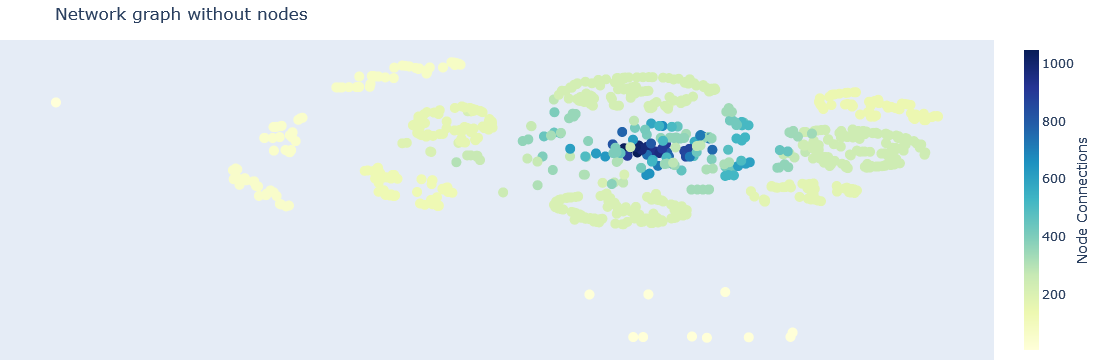

In [12]:
G = nx.Graph()

for entity in df['Entity'].unique():
    G.add_node(entity)

for entities in grouped:
    for i in range(len(entities)):
        for j in range(i + 1, len(entities)):
            if G.has_edge(entities[i], entities[j]):
                G[entities[i]][entities[j]]['weight'] += 1
            else:
                G.add_edge(entities[i], entities[j], weight=1)


pos = nx.spring_layout(G)

# Node trace
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_trace = go.Scattergl(  # Use Scattergl here for better performance with large datasets
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        color=[G.degree[v] for v in G.nodes()],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        )
    ),
    text=[f'{node}: {G.degree[node]} connections' for node in G.nodes()])

# Create the figure without edges
fig = go.Figure(data=[node_trace],
                layout=go.Layout(
                    title='Network graph without nodes',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

### Conclusions
In this notebook, I presented the code that visualizes the data we obtained earlier. So far it was the hardest part of the project. With these figures, we can start analyzing them in phase 4.

--------------
Illia Nestenko